In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from google.colab import userdata
token =userdata.get('Cryptonite-Token')

In [3]:
!git config --global user.email "idantsri2007@gmail.com"
!git config --global user.name "SILETRO"

In [4]:
!git clone https://{token}@github.com/SILETRO/Cryptonite-RTP-Idant.git
%cd Cryptonite-RTP-Idant

Cloning into 'Cryptonite-RTP-Idant'...
remote: Enumerating objects: 122, done.
remote: Counting objects: 100% (122/122), done.
remote: Compressing objects: 100% (96/96), done.
remote: Total 122 (delta 43), reused 90 (delta 23), pack-reused 0 (from 0)
Receiving objects: 100% (122/122), 3.10 MiB | 26.91 MiB/s, done.
Resolving deltas: 100% (43/43), done.
/content/Cryptonite-RTP-Idant


In [5]:
!mkdir Task-5

In [6]:
!cp '/content/drive/MyDrive/Colab Notebooks/Fashin_MNIST_CNN.ipynb' Task-5/

cp: cannot stat '/content/drive/MyDrive/Colab Notebooks/Fashin_MNIST_CNN.ipynb': No such file or directory


In [ ]:
!git add .

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path = '/content/office_script_clean.txt'
text = open(path, 'rb').read().decode(encoding='utf-8')

tf_chars = tf.strings.unicode_split(text, input_encoding='UTF-8')

In [3]:
len(tf_chars)

3427466

In [4]:
char_to_id = tf.keras.layers.StringLookup(  #text to id
    mask_token=None
)
char_to_id.adapt(tf_chars)

id_to_char = tf.keras.layers.StringLookup(  #id to text
    vocabulary=char_to_id.get_vocabulary(),
    invert=True,
    mask_token=None
)

In [5]:
char_to_id.get_vocabulary()[:10]

['[UNK]',
 np.str_(' '),
 np.str_('e'),
 np.str_('t'),
 np.str_('o'),
 np.str_('a'),
 np.str_('i'),
 np.str_('n'),
 np.str_('h'),
 np.str_('s')]

In [6]:
all_ids = char_to_id(tf_chars)
chars_sample = id_to_char(all_ids)

In [7]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

n_total = len(all_ids)
n_train = int(n_total * 0.8)
n_val = int(n_total * 0.1)

n_test = n_total - n_train - n_val

train_ds = ids_dataset.take(n_train)
remaining_ds = ids_dataset.skip(n_train)
val_ds = remaining_ds.take(n_val)
test_ds = remaining_ds.skip(n_val)

In [8]:
seq_length = 300
BATCH_SIZE = 64
BUFFER_SIZE = 10000  # For shuffling memory buffer

def split_input_target(sequence):
    input_text = sequence[:-1]  #take the characters except the target one
    target_text = sequence[1:]  #shift by one character
    return input_text, target_text

train_sequences = train_ds.batch(seq_length + 1, drop_remainder=True) #this splits the train_ds into multiple batches of 251 characters
train_dataset = (train_sequences.map(split_input_target).shuffle(BUFFER_SIZE) #this forms batches according to split_input_target
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

val_sequences = val_ds.batch(seq_length + 1, drop_remainder=True)
val_dataset_processed = (val_sequences.map(split_input_target)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

test_sequences = test_ds.batch(seq_length + 1, drop_remainder=True)
test_dataset_processed = (test_sequences.map(split_input_target)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

In [9]:
for x in train_sequences.take(1):
  print(x.shape)

(301,)


In [10]:
for x,y in train_dataset.take(1):
  print(x.shape)
  print(y.shape)

(64, 300)
(64, 300)


In [11]:
vocab_size = len(char_to_id.get_vocabulary())
from tensorflow.keras.layers import LSTM
import keras_hub

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=256),
    tf.keras.layers.LSTM(1024, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(1024, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(vocab_size)
])

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[keras_hub.metrics.Perplexity(from_logits=True, name="perplexity")]
              )

In [12]:
import os

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "cp_{epoch}.weights.h5")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True,
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    mode='min'
)

In [13]:
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset_processed,
    callbacks=[checkpoint_callback, early_stopping]
)

train_loss = history.history['loss']
val_loss = history.history['val_loss']

train_perplexity = [np.exp(loss) for loss in train_loss]
val_perplexity = [np.exp(loss) for loss in val_loss]

Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 87s 523ms/step - loss: 3.1958 - perplexity: 27.1596 - val_loss: 1.9942 - val_perplexity: 7.3461
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 82s 543ms/step - loss: 1.8055 - perplexity: 6.0982 - val_loss: 1.5733 - val_perplexity: 4.8228
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 83s 550ms/step - loss: 1.4769 - perplexity: 4.3803 - val_loss: 1.4213 - val_perplexity: 4.1426
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 82s 546ms/step - loss: 1.3447 - perplexity: 3.8374 - val_loss: 1.3466 - val_perplexity: 3.8444
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 82s 552ms/step - loss: 1.2685 - perplexity: 3.5558 - val_loss: 1.3035 - val_perplexity: 3.6820
Epoch 6/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 142s 547ms/step - loss: 1.2188 - perplexity: 3.3831 - val_loss: 1.2749 - val_perplexity: 3.5783
Epoch 7/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 82s 549ms/step - loss: 1.1838 - perplexity: 3.2667 - val_loss: 1.2575 - val_perplexity: 3.5167
Epoch 8/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 82s 554ms/ste

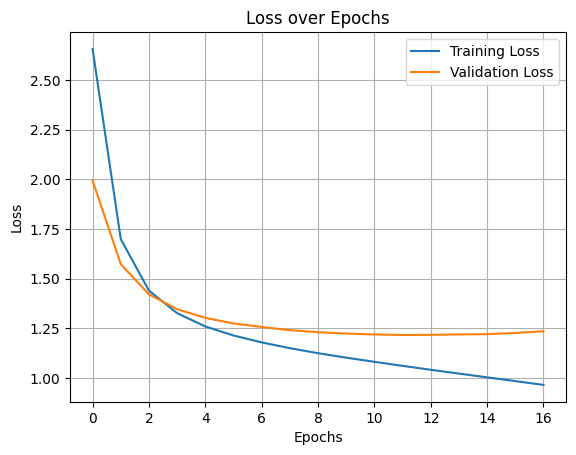

In [14]:
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()


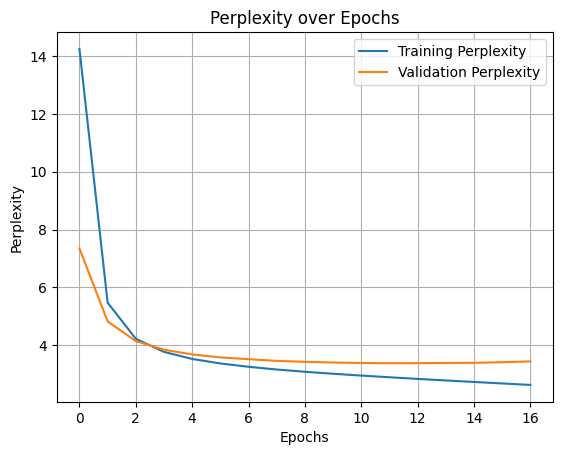

In [15]:
plt.plot(train_perplexity, label='Training Perplexity')
plt.plot(val_perplexity, label='Validation Perplexity')
plt.title('Perplexity over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.grid(True)
plt.legend()

In [16]:
model.evaluate(test_dataset_processed)

17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 164ms/step - loss: 1.2049 - perplexity: 3.3366


[1.2142066955566406, 3.367621421813965]

In [17]:
def generate_script(model, seed_text, temperature=1.0, num_tokens_to_generate=1000):
    input_ids = char_to_id(tf.strings.unicode_split(seed_text, 'UTF-8'))
    input_ids = tf.expand_dims(input_ids, 0)

    text_generated = []

    for i in range(num_tokens_to_generate):

        predictions = model(input_ids)  #outputs the probabilities of nect character
        predictions = predictions[:, -1, :] #fetches the last character
        predictions = predictions / temperature

        predicted_id = tf.random.categorical(predictions, num_samples=1)

        input_ids = tf.concat([input_ids, predicted_id], axis=-1)
        text_generated.append(id_to_char(predicted_id))

    return seed_text + tf.strings.reduce_join(text_generated).numpy().decode("utf-8")

seed = "Michael: "

In [21]:
text1 = generate_script(model, seed, temperature=0.3, num_tokens_to_generate=3000)

In [24]:
all_ids_text1 = char_to_id(tf.strings.unicode_split(text1, 'UTF-8'))
ids_dataset_text1 = tf.data.Dataset.from_tensor_slices(all_ids_text1)

text1_sequences = ids_dataset_text1.batch(seq_length + 1, drop_remainder=True)
text1_dataset_processed = (
    text1_sequences.map(split_input_target)
    .batch(BATCH_SIZE, drop_remainder=False) # Changed drop_remainder to False
    .prefetch(tf.data.AUTOTUNE)
)

results = model.evaluate(text1_dataset_processed)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step - loss: 0.6109 - perplexity: 1.8421
Perplexity: 1.8420628309249878


In [27]:
text2 = generate_script(model, seed_text = "Pam: ", temperature=0.7, num_tokens_to_generate=3000)

In [28]:
all_ids_text2 = char_to_id(tf.strings.unicode_split(text2, 'UTF-8'))
ids_dataset_text2 = tf.data.Dataset.from_tensor_slices(all_ids_text2)

text2_sequences = ids_dataset_text2.batch(seq_length + 1, drop_remainder=True)
text2_dataset_processed = (
    text2_sequences.map(split_input_target)
    .batch(BATCH_SIZE, drop_remainder=False)
    .prefetch(tf.data.AUTOTUNE)
)

results = model.evaluate(text2_dataset_processed)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.8246 - perplexity: 2.2809


In [30]:
text3 = generate_script(model, seed_text = "Jim: ", temperature=1, num_tokens_to_generate=3000)

In [32]:
all_ids_text3 = char_to_id(tf.strings.unicode_split(text3, 'UTF-8'))
ids_dataset_text3 = tf.data.Dataset.from_tensor_slices(all_ids_text3)

text3_sequences = ids_dataset_text3.batch(seq_length + 1, drop_remainder=True)
text3_dataset_processed = (
    text3_sequences.map(split_input_target)
    .batch(BATCH_SIZE, drop_remainder=False)
    .prefetch(tf.data.AUTOTUNE)
)

results = model.evaluate(text3_dataset_processed)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 1.0634 - perplexity: 2.8963
